BloomTech Data Science

*Unit 2, Sprint 2, Module 1*

---

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    
# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Decision Trees

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

In [ ]:
#Connect to remote data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/My Drive/Kaggle
#%ls 

Mounted at /content/drive
/content/drive/My Drive/Kaggle


# Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. **We recommend that you choose a username that's based on your name, since you might include it in your resume in the future.** Go to our Kaggle InClass competition website (the URL is in Slack). Go to the **Rules** page. Accept the rules of the competition. Notice that the **Rules** page also has instructions for the Submission process. The **Data** page has feature definitions.

# I. Wrangle Data

In [ ]:
# Import Block
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop duplicate columns
    #automatic method is too unreliable
    #dupe_cols = [col for col in df.head(50).T.duplicated().index
    #             if df.head(50).T.duplicated()[col]]
    dupe_cols = ['subvillage', 'region', 'extraction_type_group', 'payment', 
                 'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group']
    df.drop(columns=dupe_cols, inplace=True)    

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)   

    return df

**Task 1:** Using the `wrangle` function above, read the `train_features.csv` and  `train_labels.csv` files into the DataFrame `df`. Next, use the same function to read the test set `test_features.csv` into the DataFrame `X_test`.

In [ ]:
df = wrangle("train_features.csv", "train_labels.csv")
X_test = wrangle("test_features.csv")
print(df.head())
print(X_test.head())

         amount_tsh  gps_height  longitude  latitude  num_private  \
id                                                                  
454.0          50.0      2092.0  35.426020 -4.227446          NaN   
510.0           NaN         NaN  35.510074 -5.724555          NaN   
14146.0         NaN         NaN  32.499866 -9.081222          NaN   
47410.0         NaN         NaN  34.060484 -8.830208          NaN   
1288.0        300.0      1023.0  37.032690 -6.040787          NaN   

               basin  region_code  district_code  population public_meeting  \
id                                                                            
454.0       Internal           21            1.0       160.0           True   
510.0       Internal            1            6.0         NaN           True   
14146.0   Lake Rukwa           12            6.0         NaN           True   
47410.0       Rufiji           12            7.0         NaN           True   
1288.0   Wami / Ruvu            5         

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [ ]:
X = df.drop(['status_group'], axis=1)
y = df['status_group']

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
model_dum = DummyClassifier(strategy='prior').fit(X_train, y_train)
baseline_acc = accuracy_score(y_train, model_dum.predict(X_train))
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425489938182296


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_dt`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `DecisionTreeClassifier`.

In [ ]:
model_dt = make_pipeline(OrdinalEncoder(), SimpleImputer(), DecisionTreeClassifier(random_state=42)).fit(X_train, y_train)

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_dt`.

In [ ]:
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.995475470209128
Validation Accuracy Score: 0.7442129629629629


# VI. Tune Model

**Task 8:** Is there a large difference between your training and validation accuracy? If so, experiment with different setting for `max_depth` in your `DecisionTreeClassifier` to reduce the amount of overfitting in your model.

In [ ]:
# Use this cell to experiment and then change 
# your model hyperparameters in Task 6
print("Tree Depth: ", model_dt.named_steps['decisiontreeclassifier'].tree_.max_depth)
print("Tree Nodes: ", model_dt.named_steps['decisiontreeclassifier'].tree_.node_count)

# new model + tests below
model_dtv2 = make_pipeline(OrdinalEncoder(drop_invariant=True), SimpleImputer(strategy='most_frequent'), 
                           DecisionTreeClassifier(random_state=42, max_leaf_nodes=2000, max_depth=30,
                                                  max_features=0.5)).fit(X_train, y_train)

training_acc2 = accuracy_score(y_train, model_dtv2.predict(X_train))
val_acc2 = accuracy_score(y_val, model_dtv2.predict(X_val))

print('New Training Accuracy Score:', training_acc2)
print('New Validation Accuracy Score:', val_acc2)

print("New Tree Depth: ", model_dtv2.named_steps['decisiontreeclassifier'].tree_.max_depth)
print("New Tree Nodes: ", model_dtv2.named_steps['decisiontreeclassifier'].tree_.node_count)

Tree Depth:  37
Tree Nodes:  15197
New Training Accuracy Score: 0.8708667631198211
New Validation Accuracy Score: 0.7761994949494949
New Tree Depth:  28
New Tree Nodes:  3999


In [ ]:

# Generate test results with the revised model above

predictions = pd.DataFrame(data=model_dtv2.predict(X_test), index=X_test.index)
predictions.columns = ['status_group']

# generate CSV
predictions.to_csv('submission_jd_1.csv', )
# download
from google.colab import files
files.download("submission_jd_1.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# VII. Communicate Results

**Task 9 `stretch goal`:** Create a horizontal barchart that shows the the 10 most important features for model_dt, sorted by value.

**Note:** [`DecisionTreeClassifier.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreecla#sklearn.tree.DecisionTreeClassifier.feature_importances_) returns values that are different from [`LogisticRegression.coef_`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). All the values will be positive, and they will sum to `1`.

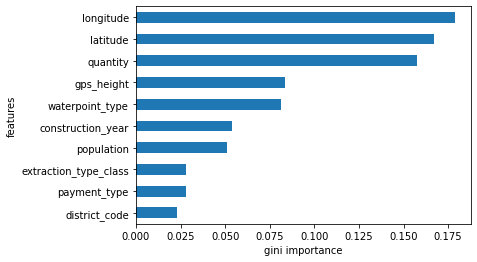

In [ ]:
gini_imp = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
feats = model_dt.named_steps['ordinalencoder'].get_feature_names()
pd.Series(data=gini_imp, index=feats).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');